In [2]:
import numpy as np
import pandas as pd

#for nlp
import nltk
from nltk.corpus import stopwords 
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

#text vectorisation
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

#metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,  roc_curve, auc

#import method releated to evaluation
from sklearn import model_selection
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

#classifiers
#from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB

#for graphs
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
filename = 'movie_data_cat.csv'
df = pd.read_csv(filename) 

In [4]:
#change labels from pos and neg to 1 and 0
class_mapping = {label:idx for idx,label in enumerate(np.unique(df['sentiment']))}

print(class_mapping)
class_labels = [x for x in class_mapping] # store the class labels for later
df["sentiment"] = df["sentiment"].map(class_mapping)
df.head(3)

{'neg': 0, 'pos': 1}


,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0


In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Matt
[nltk_data]     Christie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
stop = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

import re
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text) # remove all html markup
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text) # findall the emoticons
    
    # remove the non-word chars '[\W]+'
    # append the emoticons to end 
    #convert all to lowercase
    # remove nose char for consistency
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', '')) 
    return text


df['review'] = df['review'].apply(preprocessor)


def tokenizer(text):
       return text.split()

def tokenizer_stemmer(text):
    return [stemmer.stem(word) for word in tokenizer(text)]#text.split()]
def stop_removal(text):
       return [w for w in text if not w in stop]

In [7]:
df.loc[180, 'review']

'we could still use black adder even today imagine rowan atkinson resuming the role of assistant to the prime minister played by the wonderful hugh laurie hugh is sensational as the dimwit prince george and edmund as his brilliant assistant i love the episode which kenneth connor guest stars as a british thespian every time edmund says macbeth the two thespians do a silly little act to ward off evil spirits it s the funniest things that you will see of course none of this brilliance and comedic genius could be without ben elton and richard curtis who are also behind the films like love actually the thin blue line four weddings and a funeral black adder is funny and almost too good for television humor can be smart sexy and funny all at one i was hoping last night on saturday night live that hugh laurie would pay homage to his background in british humor if the gang at snl did some research they would know what a treasure it was to have hugh laurie grace their stage '

In [8]:
param_grid = [{'tfidfvectorizer__ngram_range': [(1, 1)], #can also extract 2-grams of words in addition to the 1-grams (individual words)
               'tfidfvectorizer__stop_words': [stop, None], # use the stop dictionary of stopwords or not
               'tfidfvectorizer__max_features': [1000, 4000], # use the stop dictionary of stopwords or not
               'tfidfvectorizer__tokenizer': [tokenizer_stemmer]}, # use a tokeniser and the stemmer 
              ]

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        #max_features=4000,
                        min_df=7,
                        preprocessor=None)

# k-Nearest Neighbors

In [9]:
pipeline = make_pipeline(TfidfVectorizer(strip_accents=None, lowercase=False, min_df=7, preprocessor=None), 
                         KNeighborsClassifier(n_neighbors=10, weights ='distance'))

gs_tfidf = GridSearchCV(pipeline, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=1) 

 # Naive Bayes

In [10]:
pipelineNB = make_pipeline(TfidfVectorizer(strip_accents=None, lowercase=False, min_df=7, preprocessor=None), 
                         MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None))

gs_tfidfNB = GridSearchCV(pipelineNB, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=1) 

# Multilayer Perceptron

In [11]:
pipelineMLP = make_pipeline(TfidfVectorizer(strip_accents=None, lowercase=False, min_df=7, preprocessor=None), 
                         MLPClassifier())

gs_tfidfMLP = GridSearchCV(pipelineMLP, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=1) 

In [12]:
X = df.loc[:, 'review'].values
y = df.loc[:, 'sentiment'].values

text_train, text_test, y_train, y_test = train_test_split(X, y, 
                                                          random_state=42,
                                                          test_size=0.25,
                                                          stratify=y)

#knn
print('KNN')
gs_tfidf.fit(text_train, y_train)
#NB
print('Naive Bayes')
gs_tfidfNB.fit(text_train, y_train)
#MLP
print('Multilayer Perceptron')
gs_tfidfMLP.fit(text_train, y_train)

KNN
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.3min finished


Naive Bayes
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.2min finished


Multilayer Perceptron
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.7min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=7,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_...=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'tfidfvectorizer__ngram_range': [(1, 1)], 'tfidfvectorizer__stop_words': [{'each', 'more', "isn't", 'are', "you'd", 'wouldn', 'for', 'had', 'hasn', 'them', 'doesn', "couldn't", 'your', "haven't", 'is', "aren't", 'then', 'myself', 'him', 'not', 'while', 'nor', 'its', 'to', 'shouldn', 'hi...: [1000, 4000], 'tfidfvectorizer__tokenizer': [<function tokenizer_stemmer at 0x0000016D8922AF28>]}],
       pre_dispatch='2*n_jobs', refit=True, return_tra

In [13]:
print('KNN')
print('Best parameter set: %s ' % gs_tfidf.best_params_)
print('CV Accuracy: %.3f' % gs_tfidf.best_score_)

KNN
Best parameter set: {'tfidfvectorizer__max_features': 4000, 'tfidfvectorizer__ngram_range': (1, 1), 'tfidfvectorizer__stop_words': {'each', 'more', "isn't", 'are', "you'd", 'wouldn', 'for', 'had', 'hasn', 'them', 'doesn', "couldn't", 'your', "haven't", 'is', "aren't", 'then', 'myself', 'him', 'not', 'while', 'nor', 'its', 'to', 'shouldn', 'himself', 'who', 'you', 'her', 'out', 'o', "shan't", 'yours', 'below', 'an', 'how', 'but', 'same', 'too', "won't", 'ain', 'now', 'against', 'itself', 'up', 'down', 'don', 'it', 'aren', 'off', 'about', "she's", 'both', 'why', 'under', 'other', 'couldn', 'again', 'ma', 'once', 'over', 'such', 'that', 'haven', "weren't", 'and', "mightn't", 'weren', 'will', 'we', 'or', 'above', 'as', 'where', 'these', 'do', 'isn', 'he', 'this', 'whom', 'mustn', 'my', "wouldn't", 'on', 'she', 'was', 'only', 'been', 'can', 'were', 'y', 'during', 'll', 'his', 'yourself', 'from', 'shan', 'just', 'through', 'wasn', 'further', 'herself', 'me', 'by', 'mightn', 'their', 'the

In [14]:
print('NB')
print('Best parameter set: %s ' % gs_tfidfNB.best_params_)
print('CV Accuracy: %.3f' % gs_tfidfNB.best_score_)

NB
Best parameter set: {'tfidfvectorizer__max_features': 4000, 'tfidfvectorizer__ngram_range': (1, 1), 'tfidfvectorizer__stop_words': {'each', 'more', "isn't", 'are', "you'd", 'wouldn', 'for', 'had', 'hasn', 'them', 'doesn', "couldn't", 'your', "haven't", 'is', "aren't", 'then', 'myself', 'him', 'not', 'while', 'nor', 'its', 'to', 'shouldn', 'himself', 'who', 'you', 'her', 'out', 'o', "shan't", 'yours', 'below', 'an', 'how', 'but', 'same', 'too', "won't", 'ain', 'now', 'against', 'itself', 'up', 'down', 'don', 'it', 'aren', 'off', 'about', "she's", 'both', 'why', 'under', 'other', 'couldn', 'again', 'ma', 'once', 'over', 'such', 'that', 'haven', "weren't", 'and', "mightn't", 'weren', 'will', 'we', 'or', 'above', 'as', 'where', 'these', 'do', 'isn', 'he', 'this', 'whom', 'mustn', 'my', "wouldn't", 'on', 'she', 'was', 'only', 'been', 'can', 'were', 'y', 'during', 'll', 'his', 'yourself', 'from', 'shan', 'just', 'through', 'wasn', 'further', 'herself', 'me', 'by', 'mightn', 'their', 'them

In [15]:
print('MLP')
print('Best parameter set: %s ' % gs_tfidfMLP.best_params_)
print('CV Accuracy: %.3f' % gs_tfidfMLP.best_score_)

MLP
Best parameter set: {'tfidfvectorizer__max_features': 4000, 'tfidfvectorizer__ngram_range': (1, 1), 'tfidfvectorizer__stop_words': None, 'tfidfvectorizer__tokenizer': <function tokenizer_stemmer at 0x0000016D8922AF28>} 
CV Accuracy: 0.801


In [16]:
clf = gs_tfidf.best_estimator_
clfNB = gs_tfidfNB.best_estimator_
clfMLP = gs_tfidfMLP.best_estimator_

print('Test Accuracy For kNN: %.3f' % clf.score(text_test, y_test))
print('Test Accuracy For NB: %.3f' % clfNB.score(text_test, y_test))
print('Test Accuracy For MLP: %.3f' % clfMLP.score(text_test, y_test))

Test Accuracy For kNN: 0.760
Test Accuracy For NB: 0.884
Test Accuracy For MLP: 0.836


In [17]:
y_pred = clf.predict(text_test)
y_pred2 = clfNB.predict(text_test)
y_pred3 = clfMLP.predict(text_test)


y_test2 = pd.Series(y_test)
y_predKNN = pd.Series(y_pred)
y_predNB = pd.Series(y_pred2)
y_predMLP = pd.Series(y_pred3)

print('kNN')
print(pd.crosstab(y_test2, y_predKNN, rownames=['True'], colnames=['Predicted'], margins=True))
print('NB')
print(pd.crosstab(y_test2, y_predNB, rownames=['True'], colnames=['Predicted'], margins=True))
print('MLP')
print(pd.crosstab(y_test2, y_predMLP, rownames=['True'], colnames=['Predicted'], margins=True))


kNN
Predicted    0    1  All
True                    
0           90   32  122
1           28  100  128
All        118  132  250
NB
Predicted    0    1  All
True                    
0          109   13  122
1           16  112  128
All        125  125  250
MLP
Predicted    0    1  All
True                    
0          109   13  122
1           28  100  128
All        137  113  250


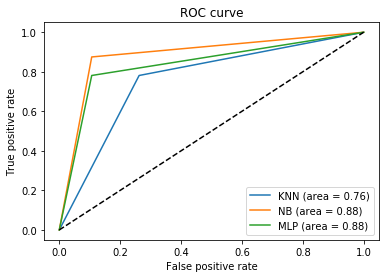

In [18]:
fpr1, tpr1, threshold1 = roc_curve(y_test, y_pred) 
fpr2, tpr2, threshold2 = roc_curve(y_test, y_pred2) 
fpr3, tpr3, threshold3 = roc_curve(y_test, y_pred3) 

# This is the AUC
auc1 = auc(fpr1, tpr1)
auc2 = auc(fpr2, tpr2)
auc3 = auc(fpr3, tpr3)
#auc = np.trapz(tpr1,fpr1)

# This is the ROC curve
plt.plot(fpr1,tpr1, label='KNN (area = %0.2f)' % (auc1))
plt.plot(fpr2,tpr2, label='NB (area = %0.2f)' % (auc2))
plt.plot(fpr3,tpr3, label='MLP (area = %0.2f)' % (auc2))
plt.plot([0, 1], [0, 1], 'k--') # diagonal

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show() 